In [1]:
%%time
import os
import numpy as np
import torch
from torch.utils.data import DataLoader, Dataset, Subset
from sklearn.model_selection import train_test_split, KFold
from torchvision import transforms
from PIL import Image
from transformers import SegformerForSemanticSegmentation, SegformerConfig, SegformerImageProcessor
import tkinter as tk
from tkinter import filedialog
import tensorflow as tf
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.metrics import jaccard_score, precision_score, recall_score, f1_score, accuracy_score
from transformers import SamModel, SamProcessor
from torch import nn
from scipy.ndimage import label, find_objects
from sklearn.model_selection import StratifiedKFold
from datetime import datetime

# DataSet
class SplashDataSet_train_val_0501(Dataset):
    def __init__(self, root_dir):
        self.root_dir = root_dir
        self.images_dir = os.path.join(self.root_dir, "images")
        self.masks_dir = os.path.join(self.root_dir, "annotations")
        # get filenames
        self.images_list = sorted(os.listdir(self.images_dir))
        self.masks_list = sorted(os.listdir(self.masks_dir))
        assert len(self.images_list) == len(self.masks_list), "Number of images and annotations should be the same."

        # transform image to 1024*1024
        self.transform = transforms.Compose([
            transforms.Resize((1024, 1024)),
            transforms.ToTensor(),  # This will scale pixel values to [0, 1]
        ])
    def __len__(self):
        return len(self.images_list)

    def __getitem__(self, idx):
        # get image and annotation file
        img_path = os.path.join(self.images_dir, self.images_list[idx])
        mask_path = os.path.join(self.masks_dir, self.masks_list[idx])
        
        image = Image.open(img_path)
        mask = Image.open(mask_path)
        
        image = self.transform(image)
        mask = self.transform(mask)

        # Convert mask to binary 0 and 1
        mask = (mask > 0).to(torch.int)
        mask = mask[0, None, :, :]
        
        return image, mask

    def get_time_category(self, filename):
        # my filenames' format is 2024-04-09-03-00-11.png
        time_str = filename.split('-')[3:5]
        time_obj = datetime.strptime('-'.join(time_str), '%H-%M')
        hour = time_obj.hour
        if hour < 8:
            return 'morning'
        elif 8 <= hour <= 16:
            return 'day'
        else:
            return 'evening'

def focal_loss(inputs, targets, alpha=0.25, gamma=2.0, reduction='mean'):
    #print("inputs size = ", inputs.size())
    # inputs size =  torch.Size([1, 2, 1024, 1024])
    #print("targets size = ", targets.size())
    # targets size =  torch.Size([1, 1024, 1024])
    BCE_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduction='none')
    targets = targets.type(torch.float32)
    at = alpha * targets + (1 - alpha) * (1 - targets)
    pt = torch.exp(-BCE_loss)
    F_loss = at * (1 - pt)**gamma * BCE_loss

    if reduction == 'mean':
        return torch.mean(F_loss)
    elif reduction == 'sum':
        return torch.sum(F_loss)
    else:
        return F_loss

# criterion
def criterion(outputs, labels):
    return torch.nn.functional.cross_entropy(outputs, labels.squeeze(1).long())

def KD_criterion(student_outputs, teacher_outputs, labels, teacher_ratio, temperature):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    #print("student_outputs size = ", student_outputs.size())
    # print("student_outputs = ", student_outputs["out"])
    #print("teacher_outputs size = ", teacher_outputs.size())
    # print("teacher_outputs = ", teacher_outputs)
    #print("ground truth size = ", labels.size())
    
    # Calculate Cross Entropy
    # original_loss = torch.nn.functional.cross_entropy(student_outputs, labels.squeeze(1).long())

    # Calculate Focal Loss , not sure about alpha and gamme
    original_loss = focal_loss(student_outputs[:,1,:,:], labels.squeeze(1).float(), alpha=0.25, gamma=2.0)

    # Calculate Distillation Loss
    soft_teacher_outputs = torch.softmax(teacher_outputs[0, 0, :, :] / temperature, dim=1)
    soft_student_outputs = torch.log_softmax(student_outputs[0, 0, :, :] / temperature, dim=1)
    distillation_loss = nn.KLDivLoss()(soft_student_outputs.to(device), soft_teacher_outputs.to(device))

    # total loss
    total_loss = (1-teacher_ratio)*original_loss + teacher_ratio*distillation_loss
    return total_loss

# evaluate
def evaluate(model, val_loader, device):
    model.eval()
    model.to(device)
    total_loss = 0.0
    with torch.no_grad():
        for image, mask in val_loader:
            image, mask = image.to(device), mask.to(device)

            outputs = model(image)

            loss = criterion(outputs['out'], mask)

            # Calculate Focal Loss , not sure about alpha and gamme
            #print("outputs size = ", outputs['out'].size())
            #print("mask size = ", mask.size())
            # outputs['out'] size =  torch.Size([1, 2, 1024, 1024])
            # mask size =  torch.Size([1, 1, 1024, 1024])
            #loss = focal_loss(outputs['out'][:,1:2,:,:], mask.float())
            total_loss += loss.item()
    avg_loss = total_loss / len(val_loader)
    print(f"Average validation loss: {avg_loss}")
    return avg_loss

# train every epoch
def train_one_epoch(student_model, teacher_model, teacher_image_processor, data_loader, teacher_ratio, temperature, optimizer, device, pbar):
    student_model.to(device)
    student_model.train()
    teacher_model.to(device)
    teacher_model.eval()
    training_loss = []
    for idx, (image, mask) in enumerate(data_loader):
        #bbox = [[[get_bounding_box(np.array(mask))]]]
        bbox, point = get_bounding_box_and_center(np.array(mask))
        #print("[train_one_epoch] bbox = ", bbox)
        #print("[train_one_epoch] point = ", point)
        image, mask = image.to(device), mask.to(device)
        # image size = torch.Size([1, 3, 1024, 1024])start_step
        # mask size = torch.Size([1, 1, 1024, 1024])

        optimizer.zero_grad()
        # output for student model ----------------------------------------------------------
        student_outputs = student_model(image)
        # outputs size = torch.Size([1, 2, 1024, 1024])
        # -----------------------------------------------------------------------------------
        # output for teacher model ----------------------------------------------------------
        # Retrieve the image embeddings
        # processor
        teacher_inputs = teacher_image_processor(image, return_tensors="pt", do_rescale=False).to(device)
        teacher_image_embeddings = teacher_model.get_image_embeddings(teacher_inputs["pixel_values"])
        
        # 送到processor計算遮罩
        if bbox is None:
            teacher_inputs = teacher_image_processor(image, return_tensors="pt", do_rescale=False).to(device)
        else:
            teacher_inputs = teacher_image_processor(image, input_points=[[[point]]], input_boxes=[[[bbox]]], return_tensors="pt", do_rescale=False).to(device)

        teacher_inputs.pop("pixel_values", None)
        teacher_inputs.update({"image_embeddings": teacher_image_embeddings})

        teacher_outputs = teacher_model(**teacher_inputs)
        teacher_masks, teacher_output = teacher_image_processor.image_processor.post_process_masks(teacher_outputs.pred_masks.cpu(), teacher_inputs["original_sizes"].cpu(), teacher_inputs["reshaped_input_sizes"].cpu())  
        # -----------------------------------------------------------------------------------
        #loss = criterion(student_outputs, mask)
        loss = KD_criterion(student_outputs['out'], teacher_output[0], mask, teacher_ratio, temperature)
        loss.backward()
        optimizer.step()
        """
        [train_one_epoch] image size =  torch.Size([1, 3, 1024, 1024])
        [train_one_epoch]0 mask size =  torch.Size([1, 1, 1024, 1024])
        [train_one_epoch]0 outputs size =  torch.Size([1, 2, 128, 128])
        [train_one_epoch]1 outputs size =  torch.Size([1, 2, 1024, 1024])
        """
        training_loss.append(loss.item())
        pbar.update(idx + 1, values=[("loss", loss.item())])
    return np.mean(np.array(training_loss))

# train
def train(model, teacher_model, teacher_image_processor, train_loader, val_loader, train_size, save_model, teacher_ratio=0.7, temperature=1):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(device, ":",torch.cuda.get_device_name(0))

    train_losses   = []
    val_losses     = []
    epochs = 10
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    best_val_loss = float('inf')

    n_batch = len(train_loader)
    pbar = tf.keras.utils.Progbar(target=n_batch, stateful_metrics=None)
    ######### weight
    # 動態生成儲存模型權重的檔名，加入目前使用的資料集大小的數字
    weight_filename = f"segformer_data_size_{train_size}.pth"
    # 確定weights資料夾是否存在，如果不存在則新增它
    #weights_dir = os.path.join(os.getcwd(),"weights")
    weights_dir = os.path.join(os.getcwd(), f"weights/weights_KD_segformer_0520/weights_KD_segformer_0520_{int(teacher_ratio*100)}")
    if not os.path.exists(weights_dir):
        os.makedirs(weights_dir)
    model_pathname = os.path.join(weights_dir, weight_filename)
    ######### weight end
    for epoch in range(epochs):
        print(f"Epoch {epoch+1}/{epochs}")
        
        train_loss = train_one_epoch(model, teacher_model, teacher_image_processor, train_loader, teacher_ratio, temperature, optimizer, device, pbar)
        train_losses.append(train_loss)

        if val_loader is not None:
            val_loss = evaluate(model, val_loader, device)
            val_losses.append(val_loss)
            pbar.update(n_batch, values=[('val_loss', val_loss)])

            if val_loss < best_val_loss and save_model:
                best_val_loss = val_loss
                torch.save(model.state_dict(), model_pathname)
                print(f"Saved model weights to '{model_pathname}'.")
    print(f"Train loss: {np.mean(train_losses)}, Validation loss: {np.mean(val_losses)}" if val_loader is not None else f"Train loss: {np.mean(train_losses)}")
    return {'loss':train_losses, 'val_loss':val_losses}

def select_folder():
    root = tk.Tk()
    root.withdraw()
    parent_folder = filedialog.askdirectory(title="選擇資料夾")
    return parent_folder

def get_bounding_box(ground_truth_map):
  ground_truth_map = ground_truth_map[0, 0, :, :]
  #print("ground_truth_map = ", ground_truth_map.shape)
  # get bounding box from mask
  y_indices, x_indices = np.where(ground_truth_map > 0)
  x_min, x_max = np.min(x_indices), np.max(x_indices)
  y_min, y_max = np.min(y_indices), np.max(y_indices)
  # add perturbation to bounding box coordinates
  H, W = ground_truth_map.shape
  x_min = max(0, x_min - np.random.randint(0, 20))
  x_max = min(W, x_max + np.random.randint(0, 20))
  y_min = max(0, y_min - np.random.randint(0, 20))
  y_max = min(H, y_max + np.random.randint(0, 20))
  bbox = [x_min, y_min, x_max, y_max]

  return bbox

def get_bounding_box_and_center(ground_truth_map):
    #print("[get_bounding_box_and_center]")
    ground_truth_map = ground_truth_map[0, 0, :, :]
    if np.any(ground_truth_map > 0):
        # get bounding box from mask
        y_indices, x_indices = np.where(ground_truth_map > 0)
        x_min, x_max = np.min(x_indices), np.max(x_indices)
        y_min, y_max = np.min(y_indices), np.max(y_indices)
        # add perturbation to bounding box coordinates
        H, W = ground_truth_map.shape
        x_min = max(0, x_min - np.random.randint(0, 20))
        x_max = min(W, x_max + np.random.randint(0, 20))
        y_min = max(0, y_min - np.random.randint(0, 20))
        y_max = min(H, y_max + np.random.randint(0, 20))
        bbox = [x_min, y_min, x_max, y_max]

        # Identify the largest connected component (largest mask area)
        labeled_array, num_features = label(ground_truth_map > 0)
        if num_features > 0:
            # Find the largest component
            max_label = 1 + np.argmax([np.sum(labeled_array == i) for i in range(1, num_features+1)])
            # Get the slice for the largest component
            largest_component_slice = find_objects(labeled_array == max_label)[0]
            yc, xc = largest_component_slice
            center_x = xc.start + (xc.stop - xc.start) // 2
            center_y = yc.start + (yc.stop - yc.start) // 2
            center_point = (center_x, center_y)
        else:
            center_point = ((x_min + x_max) // 2, (y_min + y_max) // 2)
    else:
        bbox = None
        center_point = None
    return bbox, center_point

class MySegFormer_0409(nn.Module):
    def __init__(self,num_classes,backbone="b1",id2label=None):
        super().__init__()
        self.num_classes = num_classes
        if id2label is not None:
            self.id2label = id2label
        else:
            self.id2label = {i:str(i) for i in range(self.num_classes)}
        self.segformer = SegformerForSemanticSegmentation.from_pretrained(f"nvidia/mit-{backbone}",
                                                         num_labels=self.num_classes, 
                                                         id2label=self.id2label, 
                                                         label2id={v:k for k,v in self.id2label.items()}
                                                         , ignore_mismatched_sizes=True)
    def forward(self,x):
        y = self.segformer(x)
        y = nn.functional.interpolate(y.logits, size=x.shape[-2:], mode="bilinear", align_corners=False,antialias=True)        
        return {'out':y}

# Student Model: Segformer 0409
model_name = "nvidia/mit-b0"
num_classes = 2
model_segformer = MySegFormer_0409(num_classes)

# Teacher Model: Segment Anything Model
model_sam = SamModel.from_pretrained("facebook/sam-vit-huge")
processor_sam = SamProcessor.from_pretrained("facebook/sam-vit-huge")

train_sizes = [5, 10, 15, 20, 25, 30, 50, 60, 70, 80, 90, 100, 120, 150, 180, 200, 250, 300]
#train_sizes = [300]
# 放所有 fold 的 平均、標準差
mean_val_losses = []
std_val_losses = []
root_dir = select_folder()

#root_dir = "C:/Users/user/Desktop/NAS_data/鱸魚/高雄黃明和/train_0418"
#print(root_dir)

# My DataSet, return image, mask
train_val_dataset = SplashDataSet_train_val_0501(root_dir=root_dir)
labels = [train_val_dataset.get_time_category(filename) for filename in train_val_dataset.images_list]
#print("indices 1= ", indices)
#print("label size = ", label.size())
#print("label = ", len(labels))
#print("len(train_val_dataset = )", len(train_val_dataset))
for train_size in train_sizes:
    # 在前一個大小的資料袋中擴增資料(train+validation)
    indices = np.arange(len(train_val_dataset))
    indices = indices[:train_size]
    # print("indices = ", indices)
    # Stratified K-Fold
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    val_losses = []  # 放每個 fold 的 validation loss
    for fold, (train_idx, val_idx) in enumerate(skf.split(indices, [labels[i] for i in indices])):
        print(f'FOLD {fold+1}')
        print('--------------------------------')
        train_idx = indices[train_idx]
        val_idx = indices[val_idx]
        """
        for i in indices:
            print("i = ", i)
            print("labels[i] = ", labels[i])
        print("----")
        """
        
        train_subset = Subset(train_val_dataset, train_idx)
        val_subset = Subset(train_val_dataset, val_idx)

        train_loader = DataLoader(train_subset, batch_size=1, shuffle=True)
        val_loader = DataLoader(val_subset, batch_size=1, shuffle=False)
        # train
        teacher_ratio = 0.4
        temperature = 5
        lc = train(model_segformer, model_sam, processor_sam, train_loader, val_loader, train_size, True, teacher_ratio, temperature)

        val_loss = lc['val_loss']
        val_losses.append(val_loss)
    mean_val_losses.append(np.mean(val_losses))
    std_val_losses.append(np.std(val_losses))


c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b1 and are newly initialized: ['decode_head.batch_norm.bias', 'decode_head.batch_norm.num_batches_tracked', 'decode_head.batch_norm.running_mean', 'decode_head.batch_norm.running_var', 'decode_head.batch_norm.weight', 'decode_head.classifier.bias', 'decode_head.classifier.weight', 'decode_head.linear_c.0.proj.bias', 'decode_head.linear_c.0.proj.weight', 'decode_head.linear_c.1.proj.bias', 'decode_head.linear_c.1.proj.weight', 'decode_head.linear_c.2.proj.bias', 'decode_head.linear_c.2.proj.weight', 'decode_head.linear_c.3.proj.bias', 'decode_head.linear_c.3.proj.weight', 'decode_head.linear_fuse.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


FOLD 1
--------------------------------
cuda : NVIDIA GeForce RTX 4090
Epoch 1/10
1/4 [======>.......................] - ETA: 11s - loss: 0.0792

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


4/4 [==============================] - 6s 589ms/step - loss: 0.0659
Average validation loss: 0.7181549072265625
4/4 [==============================] - 6s 604ms/step - loss: 0.0659 - val_loss: 0.7182
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_40\segformer_data_size_5.pth'.
Epoch 2/10
4/4 [==============================] - 8s 592ms/step - loss: 0.0490 - val_loss: 0.7182
Average validation loss: 0.47041377425193787
4/4 [==============================] - 8s 609ms/step - loss: 0.0490 - val_loss: 0.5943
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_40\segformer_data_size_5.pth'.
Epoch 3/10
4/4 [==============================] - 11s 585ms/step - loss: 0.0380 - val_loss: 0.5943
Average validation loss: 0.3956652879714966
4/4 [==============================] - 11s 600ms/step - loss: 0.0380 - val_los

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


8/8 [==============================] - 6s 785ms/step - loss: 0.0020
Average validation loss: 0.30508796870708466
8/8 [==============================] - 6s 797ms/step - loss: 0.0020 - val_loss: 0.3051
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_40\segformer_data_size_10.pth'.
Epoch 2/10
8/8 [==============================] - 13s 775ms/step - loss: 0.0019 - val_loss: 0.3051
Average validation loss: 0.0014382043154910207
8/8 [==============================] - 13s 786ms/step - loss: 0.0019 - val_loss: 0.1533
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_40\segformer_data_size_10.pth'.
Epoch 3/10
8/8 [==============================] - 19s 783ms/step - loss: 0.0019 - val_loss: 0.1533
Average validation loss: 4.04066413466353e-05
8/8 [==============================] - 19s 795ms/step - loss: 0.0019 

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


12/12 [==============================] - 9s 713ms/step - loss: 0.0028
Average validation loss: 0.03202622094977414
12/12 [==============================] - 9s 726ms/step - loss: 0.0028 - val_loss: 0.0320
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_40\segformer_data_size_15.pth'.
Epoch 2/10
12/12 [==============================] - 17s 726ms/step - loss: 0.0026 - val_loss: 0.0320
Average validation loss: 0.03757250057727409
12/12 [==============================] - 18s 741ms/step - loss: 0.0026 - val_loss: 0.0348
Epoch 3/10
12/12 [==============================] - 26s 717ms/step - loss: 0.0025 - val_loss: 0.0348
Average validation loss: 0.03525222775836786
12/12 [==============================] - 26s 728ms/step - loss: 0.0025 - val_loss: 0.0350
Epoch 4/10
12/12 [==============================] - 35s 731ms/step - loss: 0.0024 - val_loss: 0.0350
Average validation loss: 0.04677699444194635
12

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


16/16 [==============================] - 12s 724ms/step - loss: 0.0023
Average validation loss: 0.04255430866032839
16/16 [==============================] - 12s 736ms/step - loss: 0.0023 - val_loss: 0.0426
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_40\segformer_data_size_20.pth'.
Epoch 2/10
16/16 [==============================] - 24s 729ms/step - loss: 0.0023 - val_loss: 0.0426
Average validation loss: 0.11042357422411442
16/16 [==============================] - 24s 742ms/step - loss: 0.0023 - val_loss: 0.0765
Epoch 3/10
16/16 [==============================] - 36s 731ms/step - loss: 0.0023 - val_loss: 0.0765
Average validation loss: 0.04168096196372062
16/16 [==============================] - 36s 743ms/step - loss: 0.0023 - val_loss: 0.0649
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_40

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


20/20 [==============================] - 14s 714ms/step - loss: 0.0016
Average validation loss: 0.11627612726297229
20/20 [==============================] - 15s 726ms/step - loss: 0.0016 - val_loss: 0.1163
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_40\segformer_data_size_25.pth'.
Epoch 2/10
20/20 [==============================] - 30s 740ms/step - loss: 0.0015 - val_loss: 0.1163
Average validation loss: 0.07888106927275658
20/20 [==============================] - 30s 753ms/step - loss: 0.0015 - val_loss: 0.0976
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_40\segformer_data_size_25.pth'.
Epoch 3/10
20/20 [==============================] - 44s 711ms/step - loss: 0.0014 - val_loss: 0.0976
Average validation loss: 0.18440927267074586
20/20 [==============================] - 44s 723ms/step - lo

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


24/24 [==============================] - 18s 730ms/step - loss: 0.0013
Average validation loss: 0.1019747828443845
24/24 [==============================] - 18s 741ms/step - loss: 0.0013 - val_loss: 0.1020
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_40\segformer_data_size_30.pth'.
Epoch 2/10
24/24 [==============================] - 35s 709ms/step - loss: 0.0012 - val_loss: 0.1020
Average validation loss: 0.12535474821925163
24/24 [==============================] - 35s 720ms/step - loss: 0.0012 - val_loss: 0.1137
Epoch 3/10
24/24 [==============================] - 52s 709ms/step - loss: 0.0012 - val_loss: 0.1137
Average validation loss: 0.0662434883415699
24/24 [==============================] - 52s 721ms/step - loss: 0.0012 - val_loss: 0.0979
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_40\s

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


40/40 [==============================] - 29s 717ms/step - loss: 0.0016
Average validation loss: 0.054124101623892786
40/40 [==============================] - 29s 729ms/step - loss: 0.0016 - val_loss: 0.0541
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_40\segformer_data_size_50.pth'.
Epoch 2/10
40/40 [==============================] - 58s 717ms/step - loss: 0.0015 - val_loss: 0.0541
Average validation loss: 0.05239704586565495
40/40 [==============================] - 58s 729ms/step - loss: 0.0015 - val_loss: 0.0533
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_40\segformer_data_size_50.pth'.
Epoch 3/10
40/40 [==============================] - 87s 711ms/step - loss: 0.0015 - val_loss: 0.0533
Average validation loss: 0.11307912170886994
40/40 [==============================] - 87s 724ms/step - l

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


48/48 [==============================] - 34s 711ms/step - loss: 0.0013
Average validation loss: 0.1739229920009772
48/48 [==============================] - 35s 723ms/step - loss: 0.0013 - val_loss: 0.1739
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_40\segformer_data_size_60.pth'.
Epoch 2/10
48/48 [==============================] - 69s 712ms/step - loss: 0.0012 - val_loss: 0.1739
Average validation loss: 0.21411745871106783
48/48 [==============================] - 70s 724ms/step - loss: 0.0012 - val_loss: 0.1940
Epoch 3/10
48/48 [==============================] - 105s 727ms/step - loss: 0.0011 - val_loss: 0.1940
Average validation loss: 0.1745303055892388
48/48 [==============================] - 105s 739ms/step - loss: 0.0011 - val_loss: 0.1875
Epoch 4/10
48/48 [==============================] - 140s 716ms/step - loss: 0.0010 - val_loss: 0.1875
Average validation loss: 0.12166701753934224

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


56/56 [==============================] - 40s 713ms/step - loss: 0.0012
Average validation loss: 0.16336485078292234
56/56 [==============================] - 41s 726ms/step - loss: 0.0012 - val_loss: 0.1634
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_40\segformer_data_size_70.pth'.
Epoch 2/10
56/56 [==============================] - 80s 711ms/step - loss: 9.8699e-04 - val_loss: 0.1634
Average validation loss: 0.16693262649433954
56/56 [==============================] - 81s 723ms/step - loss: 9.8699e-04 - val_loss: 0.1651
Epoch 3/10
56/56 [==============================] - 122s 730ms/step - loss: 8.6579e-04 - val_loss: 0.1651
Average validation loss: 0.17513634370906012
56/56 [==============================] - 123s 742ms/step - loss: 8.6579e-04 - val_loss: 0.1685
Epoch 4/10
56/56 [==============================] - 162s 709ms/step - loss: 8.0295e-04 - val_loss: 0.1685
Average validation los

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


64/64 [==============================] - 46s 715ms/step - loss: 8.9009e-04
Average validation loss: 0.14365684891527053
64/64 [==============================] - 47s 727ms/step - loss: 8.9009e-04 - val_loss: 0.1437
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_40\segformer_data_size_80.pth'.
Epoch 2/10
64/64 [==============================] - 93s 720ms/step - loss: 7.6875e-04 - val_loss: 0.1437
Average validation loss: 0.13924888567999005
64/64 [==============================] - 93s 731ms/step - loss: 7.6875e-04 - val_loss: 0.1415
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_40\segformer_data_size_80.pth'.
Epoch 3/10
64/64 [==============================] - 139s 711ms/step - loss: 6.8764e-04 - val_loss: 0.1415
Average validation loss: 0.20495237410068512
64/64 [==============================] 

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


72/72 [==============================] - 51s 714ms/step - loss: 0.0021
Average validation loss: 0.1488219911439551
72/72 [==============================] - 52s 725ms/step - loss: 0.0021 - val_loss: 0.1488
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_40\segformer_data_size_90.pth'.
Epoch 2/10
72/72 [==============================] - 104s 723ms/step - loss: 0.0021 - val_loss: 0.1488
Average validation loss: 0.049418403353128165
72/72 [==============================] - 105s 734ms/step - loss: 0.0021 - val_loss: 0.0991
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_40\segformer_data_size_90.pth'.
Epoch 3/10
72/72 [==============================] - 157s 719ms/step - loss: 0.0021 - val_loss: 0.0991
Average validation loss: 0.11403664491242832
72/72 [==============================] - 158s 730ms/step 

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


80/80 [==============================] - 58s 724ms/step - loss: 9.3693e-04
Average validation loss: 0.20354933217167853
80/80 [==============================] - 59s 736ms/step - loss: 9.3693e-04 - val_loss: 0.2035
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_40\segformer_data_size_100.pth'.
Epoch 2/10
80/80 [==============================] - 116s 717ms/step - loss: 7.9120e-04 - val_loss: 0.2035
Average validation loss: 0.14427350610494613
80/80 [==============================] - 117s 728ms/step - loss: 7.9120e-04 - val_loss: 0.1739
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_40\segformer_data_size_100.pth'.
Epoch 3/10
80/80 [==============================] - 174s 712ms/step - loss: 6.7801e-04 - val_loss: 0.1739
Average validation loss: 0.07263500541448593
80/80 [============================

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


96/96 [==============================] - 69s 720ms/step - loss: 0.0011
Average validation loss: 0.11901211893806855
96/96 [==============================] - 70s 731ms/step - loss: 0.0011 - val_loss: 0.1190
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_40\segformer_data_size_120.pth'.
Epoch 2/10
96/96 [==============================] - 139s 714ms/step - loss: 8.9953e-04 - val_loss: 0.1190
Average validation loss: 0.12585007121864086
96/96 [==============================] - 140s 725ms/step - loss: 8.9953e-04 - val_loss: 0.1224
Epoch 3/10
96/96 [==============================] - 209s 714ms/step - loss: 8.0892e-04 - val_loss: 0.1224
Average validation loss: 0.29414015760024387
96/96 [==============================] - 210s 725ms/step - loss: 8.0892e-04 - val_loss: 0.1797
Epoch 4/10
96/96 [==============================] - 278s 714ms/step - loss: 7.3041e-04 - val_loss: 0.1797
Average validation 

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


120/120 [==============================] - 86s 716ms/step - loss: 9.3210e-04
Average validation loss: 0.1262563983599345
120/120 [==============================] - 87s 728ms/step - loss: 9.3210e-04 - val_loss: 0.1263
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_40\segformer_data_size_150.pth'.
Epoch 2/10
120/120 [==============================] - 173s 713ms/step - loss: 7.3464e-04 - val_loss: 0.1263
Average validation loss: 0.1402563412984212
120/120 [==============================] - 174s 725ms/step - loss: 7.3464e-04 - val_loss: 0.1333
Epoch 3/10
120/120 [==============================] - 260s 716ms/step - loss: 6.5517e-04 - val_loss: 0.1333
Average validation loss: 0.1841100518902143
120/120 [==============================] - 262s 727ms/step - loss: 6.5517e-04 - val_loss: 0.1502
Epoch 4/10
120/120 [==============================] - 348s 719ms/step - loss: 5.9218e-04 - val_loss: 0.1502


c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


144/144 [==============================] - 103s 718ms/step - loss: 7.4256e-04
Average validation loss: 0.08350760753657799
144/144 [==============================] - 105s 730ms/step - loss: 7.4256e-04 - val_loss: 0.0835
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_40\segformer_data_size_180.pth'.
Epoch 2/10
144/144 [==============================] - 208s 717ms/step - loss: 6.2257e-04 - val_loss: 0.0835
Average validation loss: 0.073823471997855
144/144 [==============================] - 210s 728ms/step - loss: 6.2257e-04 - val_loss: 0.0787
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_40\segformer_data_size_180.pth'.
Epoch 3/10
144/144 [==============================] - 313s 717ms/step - loss: 5.5940e-04 - val_loss: 0.0787
Average validation loss: 0.06079978087013968
144/144 [================

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


160/160 [==============================] - 115s 722ms/step - loss: 6.0390e-04
Average validation loss: 0.21030739056792527
160/160 [==============================] - 117s 733ms/step - loss: 6.0390e-04 - val_loss: 0.2103
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_40\segformer_data_size_200.pth'.
Epoch 2/10
160/160 [==============================] - 231s 713ms/step - loss: 5.0283e-04 - val_loss: 0.2103
Average validation loss: 0.05364104274776764
160/160 [==============================] - 233s 725ms/step - loss: 5.0283e-04 - val_loss: 0.1320
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_40\segformer_data_size_200.pth'.
Epoch 3/10
160/160 [==============================] - 348s 716ms/step - loss: 4.4316e-04 - val_loss: 0.1320
Average validation loss: 0.03796459595905617
160/160 [==============

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


200/200 [==============================] - 146s 728ms/step - loss: 9.9391e-04
Average validation loss: 0.0949761301279068
200/200 [==============================] - 148s 740ms/step - loss: 9.9391e-04 - val_loss: 0.0950
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_40\segformer_data_size_250.pth'.
Epoch 2/10
200/200 [==============================] - 294s 730ms/step - loss: 8.1642e-04 - val_loss: 0.0950
Average validation loss: 0.11941572843808883
200/200 [==============================] - 297s 742ms/step - loss: 8.1642e-04 - val_loss: 0.1072
Epoch 3/10
200/200 [==============================] - 442s 728ms/step - loss: 7.0991e-04 - val_loss: 0.1072
Average validation loss: 0.05224036647215513
200/200 [==============================] - 444s 739ms/step - loss: 7.0991e-04 - val_loss: 0.0889
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_s

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


  1/240 [..............................] - ETA: 3:15 - loss: 1.7132e-04

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


240/240 [==============================] - 174s 727ms/step - loss: 6.5196e-04
Average validation loss: 0.11454536811603853
240/240 [==============================] - 177s 739ms/step - loss: 6.5196e-04 - val_loss: 0.1145
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_40\segformer_data_size_300.pth'.
Epoch 2/10
240/240 [==============================] - 351s 725ms/step - loss: 5.8495e-04 - val_loss: 0.1145
Average validation loss: 0.0869684152615567
240/240 [==============================] - 354s 737ms/step - loss: 5.8495e-04 - val_loss: 0.1008
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_40\segformer_data_size_300.pth'.
Epoch 3/10
240/240 [==============================] - 529s 727ms/step - loss: 5.0493e-04 - val_loss: 0.1008
Average validation loss: 0.09734814534895123
240/240 [===============

train_size size =  18
mean_val_losses size =  18
std_val_losses size =  18
train_size =  [5, 10, 15, 20, 25, 30, 50, 60, 70, 80, 90, 100, 120, 150, 180, 200, 250, 300]
mean_val_losses =  [0.10555619477236178, 0.09574182741816685, 0.08453667751624985, 0.08091994012916985, 0.09873405116796492, 0.10871161409964164, 0.11336475985869765, 0.12430472095768588, 0.15037974438580157, 0.2210080237797787, 0.12237420647107329, 0.10698499247314901, 0.08772323497723461, 0.07825163322313082, 0.06544034747700961, 0.048375778266357194, 0.04426553539060567, 0.053475226866562385]
std_val_losses =  [0.14617224292653444, 0.094785351204477, 0.04996525019824898, 0.042142947454868816, 0.04458300128768731, 0.05940839973652204, 0.05210545205190745, 0.07558797545653181, 0.06376092193671766, 0.35120329392813926, 0.0704782694531479, 0.06564518885281115, 0.05269077799511547, 0.040332690649899486, 0.042902898620851566, 0.03059777775746618, 0.017163268673730078, 0.023130037394781165]


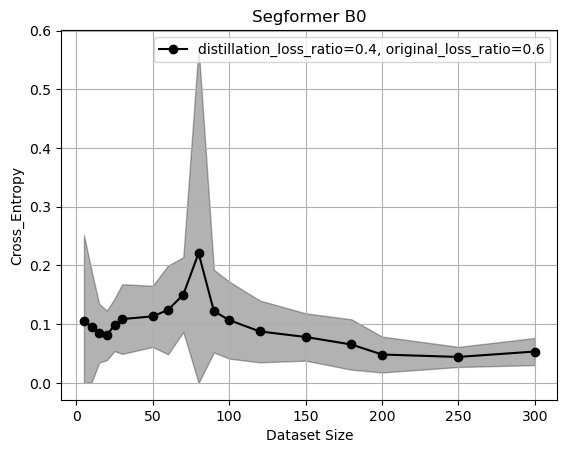

In [2]:
import os
import json

print("train_size size = ", np.array(train_sizes).size)
print("mean_val_losses size = ", np.array(mean_val_losses).size)
print("std_val_losses size = ", np.array(std_val_losses).size)
print("train_size = ", train_sizes)
print("mean_val_losses = ", mean_val_losses)
print("std_val_losses = ", std_val_losses)

results_dir = os.path.join(os.getcwd(), 'TrainingRecords', 'results_KD_segformer_0520')
if not os.path.exists(results_dir):
    os.makedirs(results_dir)

results = {
    "train_sizes": train_sizes,
    "mean_val_losses": mean_val_losses,
    "std_val_losses": std_val_losses
}
json_path = os.path.join(results_dir, f"results_KD_segformer_0520_{int(teacher_ratio*100)}.json")
with open(json_path, 'w') as json_file:
    json.dump(results, json_file, indent=4)

plt.figure()
plt.plot(train_sizes, mean_val_losses, marker='o', color='black', label=f'distillation_loss_ratio={teacher_ratio}, original_loss_ratio={round(1-teacher_ratio, 2)}')
plt.fill_between(train_sizes, np.maximum(0, np.array(mean_val_losses) - np.array(std_val_losses)), 
                 np.array(mean_val_losses) + np.array(std_val_losses), color='black', alpha=0.3)
plt.title('Segformer B0')
plt.xlabel('Dataset Size')
plt.ylabel('Cross_Entropy')
plt.grid(True)
plt.legend()
plt.savefig(os.path.join(results_dir, f"results_KD_segformer_0520_{int(teacher_ratio*100)}.png"))

plt.show()